In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\user\.conda\envs\torch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\user\.conda\envs\torch\lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device = {device}")
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

device = cuda


In [4]:
# 하이퍼파라미터 설정
latent_size = 64
hidden_size = 256
image_size = 784 # 28 * 28
num_epochs = 300
batch_size = 100

In [5]:
mnist_train # 6a

NameError: name 'mnist_train' is not defined

In [6]:
# Image Processing
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], # 1 for gray scale 만약, RGB channels라면 mean=(0.5, 0.5, 0.5)
                                         std=[0.5])])  # 1 for gray scale 만약, RGB channels라면 std=(0.5, 0.5, 0.5)

# MNIST 데이터셋
mnist_train = dsets.MNIST(root='data/',
                         train=True, # 트레인 셋
                         transform=transform,
                         download=True)
mnist_test  = dsets.MNIST(root='data/', 
                          train=False,
                          transform=transform,
                          download=True)
# 랜덤으로 9개만 시각화

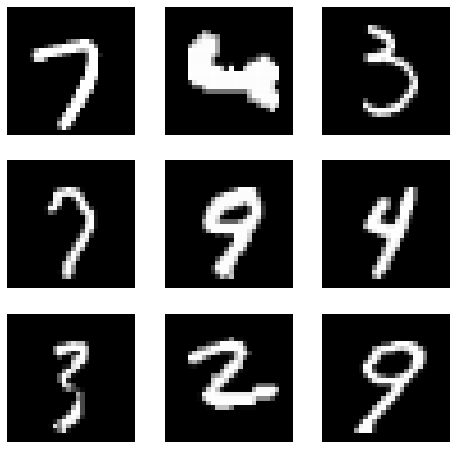

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off") # x축, y축 안보이게 설정
    plt.imshow(img.squeeze(), cmap="gray")
plt.show() 

In [8]:
print(mnist_train[0][0].squeeze().min())
print(mnist_train[0][0].squeeze().max())

tensor(-1.)
tensor(1.)


In [9]:
# 데이터 로더
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, # 훈련용 데이터 로딩
                                          batch_size=batch_size,
                                          shuffle=True) # 에폭마다 데이터 섞기

In [226]:
# Discriminator
# D = nn.Sequential(
#     nn.Linear(image_size, hidden_size),
#     nn.LeakyReLU(0.2),
#     nn.Linear(hidden_size, hidden_size),
#     nn.LeakyReLU(0.2),
#     nn.Linear(hidden_size, 1),
#     nn.Sigmoid()) # Binary Cross Entropy loss 를 사용할 것이기에 sigmoid 사용!

# Generator 
G1 = nn.Sequential(
    nn.Flatten(1), # 
    nn.Linear(784, 128), # 100*128
    nn.BatchNorm1d(128), # 100*128
    nn.LeakyReLU(0.2)) # 100*128

eta = torch.randn(batch_size, 100, device=device)

# G1_out = torch.concat((G1,eta),1).resize(batch_size,228,1,1) # 100*228*1*1

G2 = nn.Sequential( # input : G1_out
    nn.ConvTranspose2d(228,256,kernel_size=(7,7),stride=(1,1),padding=0), # [100, 256, 7, 7]
    nn.BatchNorm2d(256), # 
    nn.LeakyReLU(0.2), # [100, 256, 7, 7]
    nn.ConvTranspose2d(256,128,kernel_size=(5,5),stride=(2,2),padding=2,output_padding =1), # [100, 128, 14, 14]
    nn.BatchNorm2d(128), # 
    nn.LeakyReLU(0.2),#
    nn.ConvTranspose2d(128,1,kernel_size=(5,5),stride=(1,1),padding=2), # [100, 1, 14, 14] -> should be matched with size of y.
    nn.ReLU()# [100, 1, 14, 14]
    )

# Device setting
# D = D.to(device)
G1 = G1.to(device)
G2 = G2.to(device)

In [227]:
eta.size()

torch.Size([100, 100])

In [228]:
for batch_image,batch_label in data_loader:
    print(batch_image.size())
    print(batch_label.size())
    out1 = G1(batch_image.to(device))
    print(out1.size())
    G1_out = torch.concat((out1,eta),1).resize(batch_size,228,1,1)
    print(G1_out.size())
    print(G2(G1_out).size())
    
    break
    

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 128])
torch.Size([100, 228, 1, 1])
torch.Size([100, 1, 14, 14])


In [62]:
def imshow(img):
    img = (img+1) / 2
    img = img.squeeze() # 차원 중 사이즈 1 을 제거
    np_img = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    plt.imshow(np_img,cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach()) # 이미지 그리드 생성, 이미지 출력만을 위해 cpu에 담고 추적 방이
    img = (img+1)/2
    npimg = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [92]:
samp = torch.randn(2,28,28,device=device)
print(samp.shape)
fn = nn.Flatten(1)
res = fn(samp)
print(res.size())

torch.Size([2, 28, 28])
torch.Size([2, 784])


In [101]:
print(G1(samp).size())
eta = torch.randn(2, 100, device=device)

torch.Size([2, 128])


In [108]:
res2 = torch.concat((G1(samp),eta),1)
print(res2.size())
res2

torch.Size([2, 228])


In [99]:
# 다시 만들기

TypeError: expected Tensor as element 0 in argument 0, but got int

In [ ]:
# 생성자 이용해 데이터 만들기
rand = torch.randn(1, 100, device=device)
img_1 = G(rand).view(-1,28,28)

imshow(img_1.squeeze().cpu().detach())

In [ ]:
# Batch SIze만큼 노이즈 생성하여 그리드로 출력
rand = torch.randn(batch_size, 100, device=device)
img_1 = G(rand)
imshow_grid(img_1)

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad(): # 가중치를 0으로 초기화
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
dx_epoch = []
dgx_epoch = []
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
    
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    dx_epoch.append(real_score.mean().item())            
    dgx_epoch.append(fake_score.mean().item())
    # real image 저장
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 생성된 이미지 저장
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 생성자, 판별자 각각 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [ ]:
# plot    
plt.figure(figsize = (12, 8))
plt.xlabel('epoch')
plt.ylabel('score')
x = np.arange(num_epochs)
plt.plot(x, dx_epoch, 'g', label='D(x)')
plt.plot(x, dgx_epoch, 'b', label='D(G(z))')
plt.legend()
plt.show()